In [187]:
import numpy as np
import cv2
import glob
import copy

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

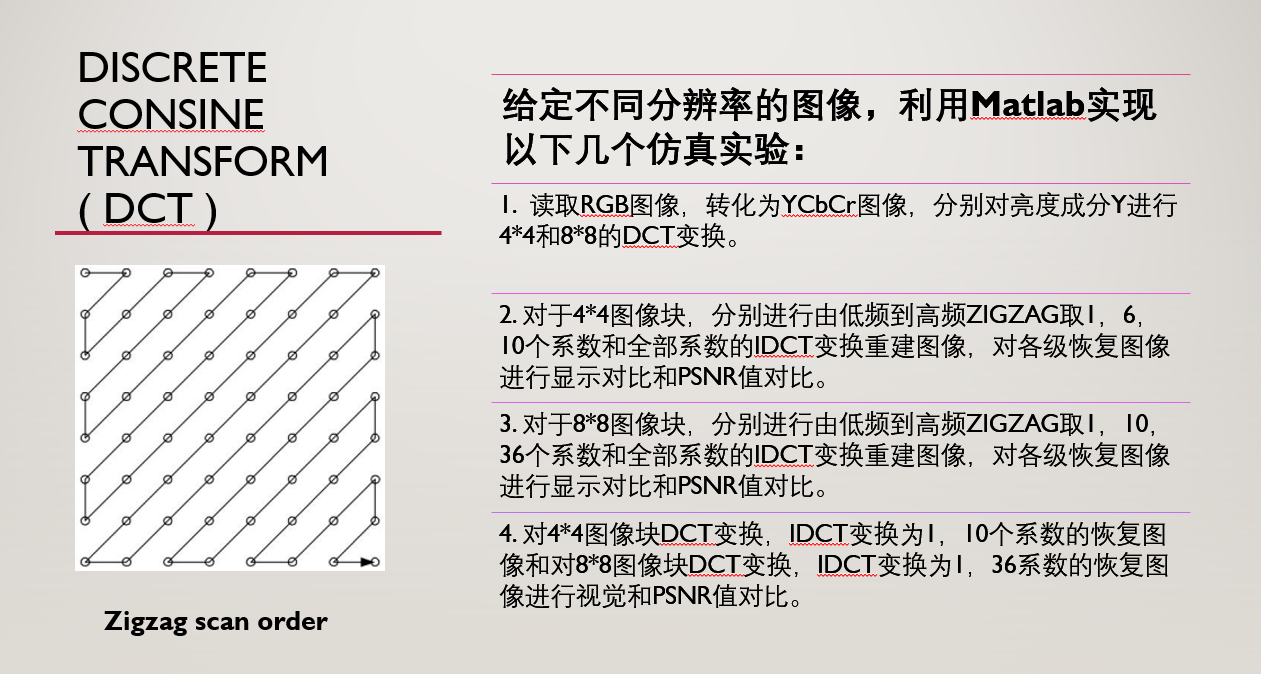

## 公用函数

In [196]:
def compute_psnr(img_in, img_sam):
    assert img_in.shape == img_sam.shape, "The sample image's shape is not same as the input!"
    
    mse = np.mean( (img_in/255. - img_sam/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    return 20 * np.log10(1 / np.sqrt(mse))

In [174]:
def divide_img(image, interval):
    h, w = image.shape
    assert h == w, "The height != width."
    
    end = h // interval
    subs = []

    for i in range(end):
        for j in range(end):
            sub = image[interval*i:interval*(i+1),interval*j:interval*(j+1)]
            subs.append(sub)
    return subs

def merge_image(sub_images, image, interval):
    h, w = image.shape
    new_image = np.zeros((h, w))
    end = h // interval
    num = 0
    for i in range(end):
        for j in range(end):
            new_image[interval*i:interval*(i+1),interval*j:interval*(j+1)] = sub_images[num]
            num += 1
    return new_image

## 1. 读入使用图像

The image shape is: (512, 512, 3)


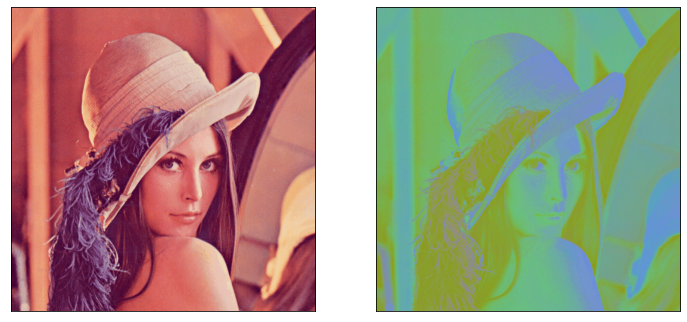

In [184]:
file = './ImageOfSY/lenna.bmp'
image = cv2.imread(file)
print(f'The image shape is: {image.shape}')

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(image[...,::-1])

image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(image_ycrcb[...,::-1])

In [172]:
y_ori, cr_ori ,cb_ori = cv2.split(image_ycrcb)

In [173]:
y_ori, y_ori.shape

(array([[158, 158, 163, ..., 166, 148, 124],
        [158, 158, 163, ..., 166, 148, 124],
        [158, 158, 163, ..., 166, 148, 124],
        ...,
        [ 40,  40,  44, ...,  98,  98,  92],
        [ 40,  40,  49, ..., 102, 102, 103],
        [ 40,  40,  49, ..., 102, 102, 103]], dtype=uint8),
 (512, 512))

## 2. 4*4

In [175]:
sub_image_y_4_4 = divide_img(y_ori, 4)
sub_image_y_8_8 = divide_img(y_ori, 8)

sub_image_y_4_4 = [np.float32(i) for i in sub_image_y_4_4]
sub_image_y_8_8 = [np.float32(i) for i in sub_image_y_8_8]

sub_image_y_4_4[0]

array([[158., 158., 163., 158.],
       [158., 158., 163., 158.],
       [158., 158., 163., 158.],
       [158., 158., 163., 158.]], dtype=float32)

计算出很多0，换了一张图像，发生了改变！

In [176]:
def merge_dct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.dct(sub_image)
        res.append(temp_dct)
    return np.array(res)

def merge_idct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.idct(sub_image)
        res.append(temp_dct)
    return np.array(res)

y_dct_4_4_no_array = merge_dct(sub_image_y_4_4)
y_dct_8_8_no_array = merge_dct(sub_image_y_8_8)
# y_dct_4_4 = y_dct_4_4_no_array.reshape(512, 512)
# y_dct_8_8 = y_dct_8_8_no_array.reshape(512, 512)

y_dct_4_4_no_array_copy = copy.deepcopy(y_dct_4_4_no_array)
y_dct_8_8_no_array_copy = copy.deepcopy(y_dct_8_8_no_array)

In [177]:
y_dct_4_4_no_array[0], y_dct_4_4_no_array.shape

(array([[637.       ,  -2.7059805,  -5.       ,   6.532815 ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ]],
       dtype=float32),
 (16384, 4, 4))

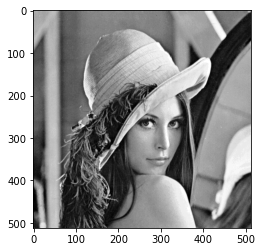

In [183]:
ori_img_recover = merge_idct(y_dct_4_4_no_array)
recover_img = merge_image(ori_img_recover, y, 4)
plt.imshow(recover_img, cmap='gray')

#### 初始合并出现问题，总是维度发生顺序错乱，所以重新写了合并图像的函数（放于前面）

In [179]:
mask_1 = [
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]

mask_4 = [
    [1, 1, 1, 0],
    [1, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 0]
]

mask_10 = [
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [1, 0, 0, 0]
]

 四张图像分别是原dct变换进行无损重建，然后取1，6，10个系数得到的图像

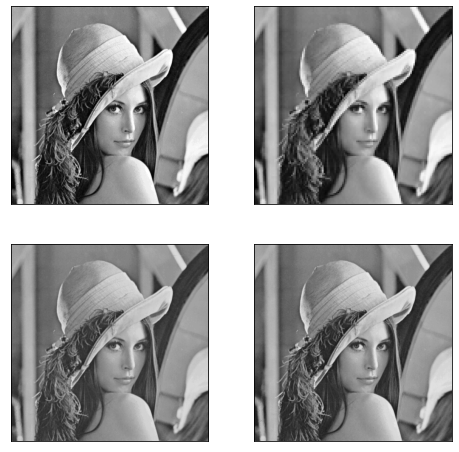

In [194]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img, cmap='gray')

y_dct_4_4_mask1 = np.array([i * mask_1 for i in y_dct_4_4_no_array_copy])
y_dct_4_4_mask1_recover = merge_idct(y_dct_4_4_mask1)
recover_img_4_4_mask1 = merge_image(y_dct_4_4_mask1_recover, y, 4)
plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_4_4_mask1, cmap='gray')

y_dct_4_4_mask2 = np.array([i * mask_4 for i in y_dct_4_4_no_array_copy])
y_dct_4_4_mask2_recover = merge_idct(y_dct_4_4_mask2)
recover_img_4_4_mask2 = merge_image(y_dct_4_4_mask2_recover, y, 4)
plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_4_4_mask2, cmap='gray')

y_dct_4_4_mask3 = np.array([i * mask_10 for i in y_dct_4_4_no_array_copy])
y_dct_4_4_mask3_recover = merge_idct(y_dct_4_4_mask3)
recover_img_4_4_mask3 = merge_image(y_dct_4_4_mask3_recover, y, 4)
plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_4_4_mask3, cmap='gray')

### 2.2 计算PSNR

In [202]:
psnr_4_4_1 = compute_psnr(y_ori, recover_img_4_4_mask1)
psnr_4_4_2 = compute_psnr(y_ori, recover_img_4_4_mask2)
psnr_4_4_3 = compute_psnr(y_ori, recover_img_4_4_mask3)
print(f'4*4 取 1 个系数的 PSNR 值为：{psnr_4_4_1:.4f}')
print(f'4*4 取 6 个系数的 PSNR 值为：{psnr_4_4_2:.4f}')
print(f'4*4 取 10 个系数的 PSNR 值为：{psnr_4_4_3:.4f}')

4*4 取 1 个系数的 PSNR 值为：26.7513
4*4 取 6 个系数的 PSNR 值为：35.4106
4*4 取 10 个系数的 PSNR 值为：37.4382


## 3. 8*8

四张图像分别是原dct变换进行无损重建，然后取1，16，36个系数得到的图像

In [181]:
mask_8_8_1 = [
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
]

mask_8_8_10 = [
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
]

mask_8_8_16 = [
    [1, 1, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
]

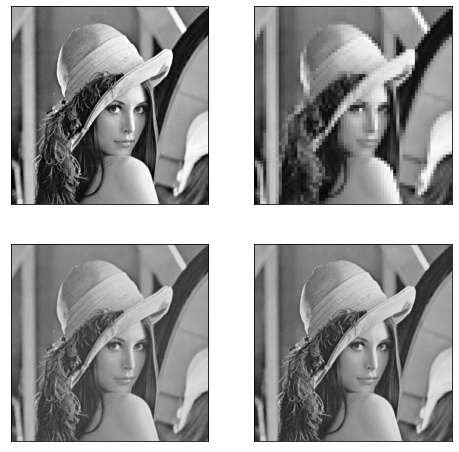

In [195]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img, cmap='gray')

y_dct_8_8_mask1 = np.array([i * mask_8_8_1 for i in y_dct_8_8_no_array_copy])
y_dct_8_8_mask1_recover = merge_idct(y_dct_8_8_mask1)
recover_img_8_8_mask1 = merge_image(y_dct_8_8_mask1_recover, y, 8)
plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_8_8_mask1, cmap='gray')

y_dct_8_8_mask2 = np.array([i * mask_8_8_10 for i in y_dct_8_8_no_array_copy])
y_dct_8_8_mask2_recover = merge_idct(y_dct_8_8_mask2)
recover_img_8_8_mask2 = merge_image(y_dct_8_8_mask2_recover, y, 8)
plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_8_8_mask2, cmap='gray')

y_dct_8_8_mask3 = np.array([i * mask_8_8_16 for i in y_dct_8_8_no_array_copy])
y_dct_8_8_mask3_recover = merge_idct(y_dct_8_8_mask3)
recover_img_8_8_mask3 = merge_image(y_dct_8_8_mask3_recover, y, 8)
plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_8_8_mask3, cmap='gray')

### 3.2 计算PSNR

In [203]:
psnr_8_8_1 = compute_psnr(y_ori, recover_img_8_8_mask1)
psnr_8_8_2 = compute_psnr(y_ori, recover_img_8_8_mask2)
psnr_8_8_3 = compute_psnr(y_ori, recover_img_8_8_mask3)
print(f'8*8 取 1 个系数的 PSNR 值为：{psnr_8_8_1:.4f}')
print(f'8*8 取 16 个系数的 PSNR 值为：{psnr_8_8_2:.4f}')
print(f'8*8 取 36 个系数的 PSNR 值为：{psnr_8_8_3:.4f}')

8*8 取 1 个系数的 PSNR 值为：23.5664
8*8 取 16 个系数的 PSNR 值为：31.5881
8*8 取 36 个系数的 PSNR 值为：35.4260


## 4. contract

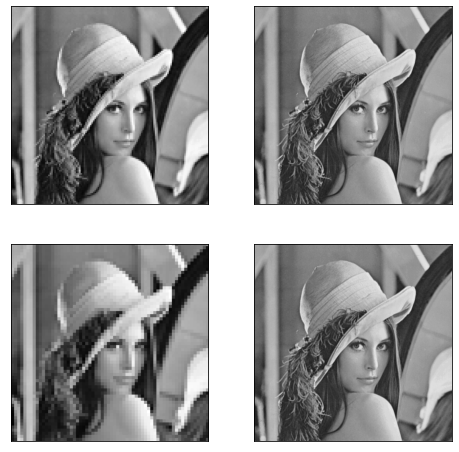

In [201]:
plt.figure(figsize=(8,8))

plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_4_4_mask1, cmap='gray')

plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_4_4_mask3, cmap='gray')

plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_8_8_mask1, cmap='gray')

plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.imshow(recover_img_8_8_mask3, cmap='gray')

In [204]:
print(f'4*4 取 1 个系数的 PSNR 值为：{psnr_4_4_1:.4f}')
print(f'4*4 取 10 个系数的 PSNR 值为：{psnr_4_4_3:.4f}')

print(f'8*8 取 1 个系数的 PSNR 值为：{psnr_8_8_1:.4f}')
print(f'8*8 取 36 个系数的 PSNR 值为：{psnr_8_8_3:.4f}')

4*4 取 1 个系数的 PSNR 值为：26.7513
4*4 取 10 个系数的 PSNR 值为：37.4382
8*8 取 1 个系数的 PSNR 值为：23.5664
8*8 取 36 个系数的 PSNR 值为：35.4260
